#Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EVA2/Assignment4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/EVA2/Assignment4


#Installing requirements

In [2]:
!pip install torch-lr-finder
!pip install torch-lr-finder -v --global-option="amp"
!pip install facenet-pytorch

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-hpw5ix7m
Created temporary directory: /tmp/pip-req-tracker-rj2kvhqe
Created requirements tracker '/tmp/pip-req-tracker-rj2kvhqe'
Created temporary directory: /tmp/pip-install-gxy5_1di
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-rj2kvhqe'


#removing redundant files, adding folder structure

In [7]:
import os
!rm -rf /content/ZData/
!mkdir /content/ZData/
!mkdir /content/ZData/Train
!mkdir /content/ZData/Val
!tar -xf lfw-funneled.tar --directory /content/ZData/
!unzip -q extra_data.zip -d /content/ZData/extra_data/
for p,d,f in os.walk('/content/ZData/extra_data/'):
  for f1 in f:
    if f1=='Thumbs.db':
      os.remove(p+'/'+f1)
!mv /content/ZData/extra_data/* /content/ZData/lfw_funneled/
!rm -rf /content/ZData/extra_data

#Managing Imports

In [2]:
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import models
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
import os
import sys
import matplotlib.pyplot as plt
from Transform_utils.transforme_album import Data
import general_utils
import torch
import torchvision
import cudas
import shutil

CUDA Available? True


#Taking data from lfw with size>4 and 10 extra folders

In [14]:
from tqdm.autonotebook import tqdm
count=0
mtcnn = MTCNN(post_process=False)
for p,d,f in os.walk('/content/ZData/lfw_funneled/'):
  for d1 in d:
    for p2,d2,f2 in os.walk(p+d1+'/'):
      if len(f2)>3:
        count = count+1
        if not os.path.exists('/content/ZData/Train/'+d1+'/'):
             os.makedirs('/content/ZData/Train/'+d1+'/')
             os.makedirs('/content/ZData/Val/'+d1+'/')
        count1 = 0
        for fx in f2:
          count1=count1+1
          im = cv2.imread(p2+fx)
          if im is not None:
            face = mtcnn(im)
            if face is not None:
              cv2.imwrite(p2+fx, face.permute(1, 2, 0).int().numpy())
            else:
              !rm -rf p2+fx
          else:
            !rm -rf p2+fx

#Split 70:30 in train and val

In [10]:
count=0
for p,d,f in os.walk('/content/ZData/lfw_funneled/'): 
  for d1 in d:
    for p2,d2,f2 in os.walk(p+d1+'/'):
      if len(f2)>9:
        count = count+1
        if not os.path.exists('/content/ZData/Train/'+d1+'/'):
             os.makedirs('/content/ZData/Train/'+d1+'/')
             os.makedirs('/content/ZData/Val/'+d1+'/')
        count1 = 0
        for fx in f2:
          count1=count1+1
          if count1<0.7*len(f2):
            shutil.copy(p2+fx, '/content/ZData/Train/'+d1+'/')
          else:
            shutil.copy(p2+fx, '/content/ZData/Val/'+d1+'/')
!rm -rf /content/ZData/lfw_funneled/

In [11]:
import zipfile
myZipFile = zipfile.ZipFile("zip_620.zip", "w" )
for p,d,f in os.walk('/content/ZData/'):
  for f1 in f:
    myZipFile.write(p+'/'+f1, p+'/'+f1 )

#Data loading

In [3]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset =  data.getTestDataSet(train=False)
trainloader = data.getDataLoader(trainset, 128)
trainloader1 = data.getDataLoader(trainset, 8)
testloader = data.getDataLoader(testset, 128)
testloader1 = data.getDataLoader(testset, 8)
classes = trainset.classes

Train Data size 3054
Test Data size 1449


#Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 160, 160])


 George_W_Bush
Recep_Tayyip_Erdogan
Venus_Williams
Tom_Ridge
Jacques_Chirac
George_W_Bush
Deepika_Padukone
Jean_Chretien


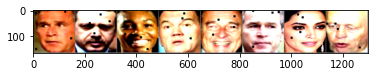

In [5]:
# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()
print(images.shape)
general_utils.imshow(torchvision.utils.make_grid(images))
print('\n\n','\n'.join('%5s' % classes[labels[j]] for j in range(8)))

#Model Loading and updation

In [15]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x
        
from models.inception_resnet_v1 import InceptionResnetV1
device = torch.device("cuda" if cudas.cuda else "cpu")
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(classes))
list(model_ft.children())[-6:]
layer_list = list(model_ft.children())[-5:] # all final layers
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False

Running on device: cuda


In [18]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, len(classes))
#model_ft.softmax = nn.Softmax(dim=1)
net = model_ft.to(device)

#Summary

In [19]:
print(net)

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

#finding peak LR

In [11]:
from torch_lr_finder import LRFinder
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0025)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.5)

In [12]:
from tqdm.notebook import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
for epoch in range(25):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
print('Finished Training')

  0%|          | 0/28 [00:00<?, ?it/s]

lr=  0.001


Epoch= 0 Loss=5.11686372756958 Batch_id=27 Accuracy=7.14: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 5.1106086 Test Accuracy= 5.074626865671642
lr=  0.0015


Epoch= 1 Loss=5.07840633392334 Batch_id=27 Accuracy=21.43: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 5.080062 Test Accuracy= 18.407960199004975
lr=  0.0022500000000000003


Epoch= 2 Loss=5.035275936126709 Batch_id=27 Accuracy=23.81: 100%|██████████| 28/28 [00:10<00:00,  2.80it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 5.0227537 Test Accuracy= 17.611940298507463
lr=  0.0033750000000000004


Epoch= 3 Loss=4.98677921295166 Batch_id=27 Accuracy=19.05: 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 5.0137997 Test Accuracy= 16.51741293532338
lr=  0.005062500000000001


Epoch= 4 Loss=4.996512413024902 Batch_id=27 Accuracy=7.14: 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.936263 Test Accuracy= 16.019900497512438
lr=  0.0075937500000000015


Epoch= 5 Loss=4.720737934112549 Batch_id=27 Accuracy=26.19: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.9062433 Test Accuracy= 15.82089552238806
lr=  0.011390625000000001


Epoch= 6 Loss=4.7757744789123535 Batch_id=27 Accuracy=16.67: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.6646957 Test Accuracy= 15.422885572139304
lr=  0.017085937500000002


Epoch= 7 Loss=4.624238967895508 Batch_id=27 Accuracy=14.29: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.578554 Test Accuracy= 15.323383084577115
lr=  0.025628906250000003


Epoch= 8 Loss=4.434576511383057 Batch_id=27 Accuracy=14.29: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.3569665 Test Accuracy= 15.323383084577115
lr=  0.03844335937500001


Epoch= 9 Loss=4.46047830581665 Batch_id=27 Accuracy=9.52: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.1429005 Test Accuracy= 16.019900497512438
lr=  0.057665039062500006


Epoch= 10 Loss=4.134932994842529 Batch_id=27 Accuracy=11.90: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.2326922 Test Accuracy= 17.412935323383085
lr=  0.08649755859375001


Epoch= 11 Loss=3.788393259048462 Batch_id=27 Accuracy=26.19: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.926857 Test Accuracy= 22.786069651741293
lr=  0.129746337890625


Epoch= 12 Loss=3.641719341278076 Batch_id=27 Accuracy=28.57: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 4.0075035 Test Accuracy= 25.870646766169155
lr=  0.1946195068359375


Epoch= 13 Loss=3.692678451538086 Batch_id=27 Accuracy=35.71: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.7199674 Test Accuracy= 30.746268656716417
lr=  0.29192926025390625


Epoch= 14 Loss=3.633040189743042 Batch_id=27 Accuracy=33.33: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.6536753 Test Accuracy= 34.92537313432836
lr=  0.43789389038085935


Epoch= 15 Loss=3.738349199295044 Batch_id=27 Accuracy=28.57: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.423308 Test Accuracy= 38.10945273631841
lr=  0.656840835571289


Epoch= 16 Loss=3.300739049911499 Batch_id=27 Accuracy=40.48: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.206047 Test Accuracy= 40.0
lr=  0.9852612533569336


Epoch= 17 Loss=2.884655475616455 Batch_id=27 Accuracy=45.24: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.3417597 Test Accuracy= 41.492537313432834
lr=  1.4778918800354004


Epoch= 18 Loss=2.6601741313934326 Batch_id=27 Accuracy=54.76: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.1934154 Test Accuracy= 43.88059701492537
lr=  2.2168378200531005


Epoch= 19 Loss=2.826389789581299 Batch_id=27 Accuracy=52.38: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.001528 Test Accuracy= 40.398009950248756
lr=  3.3252567300796505


Epoch= 20 Loss=3.005009174346924 Batch_id=27 Accuracy=59.52: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.1911907 Test Accuracy= 41.99004975124378
lr=  4.987885095119475


Epoch= 21 Loss=3.416616201400757 Batch_id=27 Accuracy=35.71: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.3183985 Test Accuracy= 39.701492537313435
lr=  7.481827642679213


Epoch= 22 Loss=3.3469104766845703 Batch_id=27 Accuracy=40.48: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.0779712 Test Accuracy= 38.00995024875622
lr=  11.222741464018819


Epoch= 23 Loss=3.9057729244232178 Batch_id=27 Accuracy=35.71: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]
  0%|          | 0/28 [00:00<?, ?it/s]

Test Loss= 3.3204446 Test Accuracy= 36.91542288557214
lr=  16.83411219602823


Epoch= 24 Loss=3.5910894870758057 Batch_id=27 Accuracy=42.86: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]
100%|██████████| 8/8 [00:02<00:00,  3.56it/s]

Test Loss= 3.7643237 Test Accuracy= 34.02985074626866
Finished Training


Text(0, 0.5, 'Accuracy')

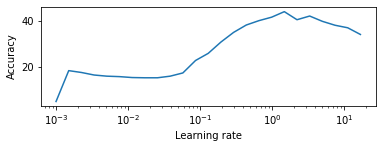

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_, test_acc)
ax.set_xscale('log')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Accuracy")

#Training

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=1.25, step_size_up=15, step_size_down=10, mode='triangular2')
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

In [21]:
from tqdm.notebook import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
for epoch in range(101):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    #if(epoch!=0 and epoch%25==0):
    scheduler.step()
print('Finished Training')

  0%|          | 0/24 [00:00<?, ?it/s]

lr=  0.005


Epoch= 0 Loss=6.3797173500061035 Batch_id=23 Accuracy=20.91: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 6.3828645 Test Accuracy= 16.63216011042098
lr=  0.08800000000000009


Epoch= 1 Loss=5.521528244018555 Batch_id=23 Accuracy=16.36: 100%|██████████| 24/24 [00:08<00:00,  2.93it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 5.4802523 Test Accuracy= 15.942028985507246
lr=  0.17100000000000018


Epoch= 2 Loss=4.831577301025391 Batch_id=23 Accuracy=18.18: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 4.8982034 Test Accuracy= 16.287094547964113
lr=  0.2540000000000002


Epoch= 3 Loss=4.330402851104736 Batch_id=23 Accuracy=26.36: 100%|██████████| 24/24 [00:08<00:00,  2.91it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 4.0865755 Test Accuracy= 25.948930296756384
lr=  0.3369999999999999


Epoch= 4 Loss=3.892212152481079 Batch_id=23 Accuracy=32.73: 100%|██████████| 24/24 [00:08<00:00,  2.87it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 4.2117076 Test Accuracy= 30.36576949620428
lr=  0.41999999999999993


Epoch= 5 Loss=3.6890580654144287 Batch_id=23 Accuracy=42.73: 100%|██████████| 24/24 [00:08<00:00,  2.82it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 3.4308066 Test Accuracy= 38.78536922015183
lr=  0.503


Epoch= 6 Loss=3.4027130603790283 Batch_id=23 Accuracy=42.73: 100%|██████████| 24/24 [00:08<00:00,  2.81it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.6495984 Test Accuracy= 42.857142857142854
lr=  0.5860000000000002


Epoch= 7 Loss=2.703040838241577 Batch_id=23 Accuracy=53.64: 100%|██████████| 24/24 [00:08<00:00,  2.82it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.6537101 Test Accuracy= 48.4472049689441
lr=  0.6690000000000002


Epoch= 8 Loss=2.8079633712768555 Batch_id=23 Accuracy=51.82: 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.3818974 Test Accuracy= 52.5879917184265
lr=  0.7519999999999999


Epoch= 9 Loss=2.603668212890625 Batch_id=23 Accuracy=56.36: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.3477325 Test Accuracy= 56.79779158040028
lr=  0.8349999999999999


Epoch= 10 Loss=2.1510729789733887 Batch_id=23 Accuracy=66.36: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.6093407 Test Accuracy= 60.869565217391305
lr=  0.918


Epoch= 11 Loss=1.9469128847122192 Batch_id=23 Accuracy=69.09: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.2584646 Test Accuracy= 65.49344375431332
lr=  1.0010000000000001


Epoch= 12 Loss=1.647134780883789 Batch_id=23 Accuracy=78.18: 100%|██████████| 24/24 [00:09<00:00,  2.64it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 2.2442372 Test Accuracy= 69.63423050379572
lr=  1.084


Epoch= 13 Loss=1.5735269784927368 Batch_id=23 Accuracy=80.91: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.5443293 Test Accuracy= 73.63699102829537
lr=  1.1670000000000003


Epoch= 14 Loss=1.6383056640625 Batch_id=23 Accuracy=75.45: 100%|██████████| 24/24 [00:09<00:00,  2.61it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.9789066 Test Accuracy= 77.36369910282954
lr=  1.2499999999999998


Epoch= 15 Loss=1.3084262609481812 Batch_id=23 Accuracy=84.55: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.0684457 Test Accuracy= 79.77915804002761
lr=  1.1254999999999995


Epoch= 16 Loss=1.1639466285705566 Batch_id=23 Accuracy=84.55: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.4536223 Test Accuracy= 81.50448585231194
lr=  1.0009999999999994


Epoch= 17 Loss=1.3016635179519653 Batch_id=23 Accuracy=83.64: 100%|██████████| 24/24 [00:09<00:00,  2.59it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.0812211 Test Accuracy= 83.57487922705315
lr=  0.8765000000000002


Epoch= 18 Loss=0.8802226781845093 Batch_id=23 Accuracy=91.82: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.2029626 Test Accuracy= 84.88612836438924
lr=  0.752


Epoch= 19 Loss=0.8934804797172546 Batch_id=23 Accuracy=91.82: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.1148459 Test Accuracy= 86.5424430641822
lr=  0.6275


Epoch= 20 Loss=0.9985166788101196 Batch_id=23 Accuracy=90.91: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.75035393 Test Accuracy= 87.92270531400966
lr=  0.5030000000000004


Epoch= 21 Loss=0.745754063129425 Batch_id=23 Accuracy=93.64: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.0752586 Test Accuracy= 89.16494133885438
lr=  0.3785000000000004


Epoch= 22 Loss=0.745323121547699 Batch_id=23 Accuracy=95.45: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.8624883 Test Accuracy= 90.06211180124224
lr=  0.2540000000000002


Epoch= 23 Loss=0.7072996497154236 Batch_id=23 Accuracy=95.45: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.8372259 Test Accuracy= 91.23533471359558
lr=  0.12950000000000012


Epoch= 24 Loss=0.743233323097229 Batch_id=23 Accuracy=94.55: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.90383995 Test Accuracy= 91.16632160110422
lr=  0.005


Epoch= 25 Loss=0.5976982116699219 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.784177 Test Accuracy= 91.37336093857833
lr=  0.04650000000000004


Epoch= 26 Loss=0.7415556907653809 Batch_id=23 Accuracy=93.64: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.67894256 Test Accuracy= 91.99447895100069
lr=  0.08800000000000009


Epoch= 27 Loss=0.8608372807502747 Batch_id=23 Accuracy=96.36: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.7199839 Test Accuracy= 91.51138716356108
lr=  0.12950000000000012


Epoch= 28 Loss=0.5991964936256409 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.7929934 Test Accuracy= 91.85645272601795
lr=  0.17100000000000018


Epoch= 29 Loss=0.647773802280426 Batch_id=23 Accuracy=96.36: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.72844577 Test Accuracy= 92.20151828847482
lr=  0.21250000000000022


Epoch= 30 Loss=0.5723462700843811 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 1.0368786 Test Accuracy= 92.33954451345755
lr=  0.2540000000000002


Epoch= 31 Loss=0.5482062697410583 Batch_id=23 Accuracy=97.27: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.56737816 Test Accuracy= 92.7536231884058
lr=  0.2955000000000003


Epoch= 32 Loss=0.6332001686096191 Batch_id=23 Accuracy=97.27: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.65329534 Test Accuracy= 93.58178053830228
lr=  0.33700000000000035


Epoch= 33 Loss=0.5293443202972412 Batch_id=23 Accuracy=97.27: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.5037891 Test Accuracy= 94.06487232574189
lr=  0.3785000000000004


Epoch= 34 Loss=0.5560970306396484 Batch_id=23 Accuracy=98.18: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.6799797 Test Accuracy= 94.13388543823326
lr=  0.41999999999999993


Epoch= 35 Loss=0.5722947120666504 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.73656166 Test Accuracy= 94.34092477570738
lr=  0.4615


Epoch= 36 Loss=0.521013081073761 Batch_id=23 Accuracy=98.18: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.6240318 Test Accuracy= 95.37612146307798
lr=  0.503


Epoch= 37 Loss=0.43788525462150574 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.7337893 Test Accuracy= 95.65217391304348
lr=  0.5445000000000001


Epoch= 38 Loss=0.5509539246559143 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.8724818 Test Accuracy= 95.92822636300897
lr=  0.5860000000000002


Epoch= 39 Loss=0.41741013526916504 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.661916 Test Accuracy= 96.13526570048309
lr=  0.6275


Epoch= 40 Loss=0.5098615884780884 Batch_id=23 Accuracy=97.27: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.47151953 Test Accuracy= 96.75638371290545
lr=  0.5652500000000006


Epoch= 41 Loss=0.40140601992607117 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.5408371 Test Accuracy= 97.37750172532782
lr=  0.5030000000000004


Epoch= 42 Loss=0.4187018573284149 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.46015513 Test Accuracy= 96.96342305037957
lr=  0.4407500000000004


Epoch= 43 Loss=0.37648504972457886 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.5054617 Test Accuracy= 97.58454106280193
lr=  0.3785000000000004


Epoch= 44 Loss=0.38644281029701233 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.508944 Test Accuracy= 97.58454106280193
lr=  0.3162500000000003


Epoch= 45 Loss=0.37477126717567444 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.41759714 Test Accuracy= 97.9296066252588
lr=  0.2540000000000002


Epoch= 46 Loss=0.299236536026001 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.66285414 Test Accuracy= 97.65355417529331
lr=  0.1917500000000002


Epoch= 47 Loss=0.3152928054332733 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3230961 Test Accuracy= 98.20565907522429
lr=  0.12950000000000012


Epoch= 48 Loss=0.3474767506122589 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3937757 Test Accuracy= 98.06763285024155
lr=  0.06725000000000006


Epoch= 49 Loss=0.2581833004951477 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3313255 Test Accuracy= 98.13664596273291
lr=  0.005


Epoch= 50 Loss=0.30122241377830505 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:09<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.2293205 Test Accuracy= 97.99861973775018
lr=  0.025750000000000023


Epoch= 51 Loss=0.3023306429386139 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.27247444 Test Accuracy= 97.86059351276742
lr=  0.04650000000000004


Epoch= 52 Loss=0.31680187582969666 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.5335643 Test Accuracy= 98.06763285024155
lr=  0.06725000000000006


Epoch= 53 Loss=0.240092933177948 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.35350516 Test Accuracy= 98.20565907522429
lr=  0.08800000000000009


Epoch= 54 Loss=0.3523601293563843 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.42729777 Test Accuracy= 97.86059351276742
lr=  0.10875000000000011


Epoch= 55 Loss=0.26944518089294434 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.43593338 Test Accuracy= 97.99861973775018
lr=  0.12950000000000012


Epoch= 56 Loss=0.371246337890625 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.35638848 Test Accuracy= 98.13664596273291
lr=  0.1502499999999999


Epoch= 57 Loss=0.2469138205051422 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.8194734 Test Accuracy= 97.99861973775018
lr=  0.17099999999999996


Epoch= 58 Loss=0.26975172758102417 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.53770155 Test Accuracy= 97.99861973775018
lr=  0.19174999999999998


Epoch= 59 Loss=0.26940715312957764 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.34691826 Test Accuracy= 98.34368530020704
lr=  0.21249999999999997


Epoch= 60 Loss=0.2842179834842682 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.44237673 Test Accuracy= 98.06763285024155
lr=  0.23325


Epoch= 61 Loss=0.2083052098751068 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.80212075 Test Accuracy= 98.06763285024155
lr=  0.254


Epoch= 62 Loss=0.29093727469444275 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.4171297 Test Accuracy= 98.13664596273291
lr=  0.27475000000000005


Epoch= 63 Loss=0.22619228065013885 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.40830258 Test Accuracy= 97.99861973775018
lr=  0.2955000000000001


Epoch= 64 Loss=0.2569359242916107 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.42951417 Test Accuracy= 97.9296066252588
lr=  0.31625


Epoch= 65 Loss=0.355095773935318 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.39786175 Test Accuracy= 97.99861973775018
lr=  0.2851249999999999


Epoch= 66 Loss=0.23591972887516022 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:09<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.45351744 Test Accuracy= 98.13664596273291
lr=  0.2539999999999999


Epoch= 67 Loss=0.20798780024051666 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.45379183 Test Accuracy= 98.27467218771567
lr=  0.22287499999999988


Epoch= 68 Loss=0.2824957072734833 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.4056025 Test Accuracy= 98.27467218771567
lr=  0.1917500000000002


Epoch= 69 Loss=0.19718199968338013 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3837356 Test Accuracy= 98.20565907522429
lr=  0.16062500000000016


Epoch= 70 Loss=0.22711233794689178 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.30038545 Test Accuracy= 98.06763285024155
lr=  0.12950000000000012


Epoch= 71 Loss=0.19409014284610748 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.31878495 Test Accuracy= 98.13664596273291
lr=  0.0983750000000001


Epoch= 72 Loss=0.2337009757757187 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.25987384 Test Accuracy= 98.13664596273291
lr=  0.06725000000000006


Epoch= 73 Loss=0.2096681445837021 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.6828401 Test Accuracy= 98.20565907522429
lr=  0.03612500000000003


Epoch= 74 Loss=0.19023220241069794 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.39689842 Test Accuracy= 98.20565907522429
lr=  0.005


Epoch= 75 Loss=0.21452969312667847 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.53175217 Test Accuracy= 98.13664596273291
lr=  0.01537500000000001


Epoch= 76 Loss=0.1630888432264328 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.5074604 Test Accuracy= 98.13664596273291
lr=  0.025750000000000023


Epoch= 77 Loss=0.17368420958518982 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.35805464 Test Accuracy= 98.20565907522429
lr=  0.03612500000000003


Epoch= 78 Loss=0.20214538276195526 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.76it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.36955374 Test Accuracy= 98.20565907522429
lr=  0.04650000000000004


Epoch= 79 Loss=0.19341424107551575 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.6048391 Test Accuracy= 98.20565907522429
lr=  0.05687500000000005


Epoch= 80 Loss=0.1689155101776123 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.2631385 Test Accuracy= 98.27467218771567
lr=  0.06725000000000006


Epoch= 81 Loss=0.18472468852996826 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.2903189 Test Accuracy= 98.06763285024155
lr=  0.07762499999999985


Epoch= 82 Loss=0.20411482453346252 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.49405438 Test Accuracy= 98.20565907522429
lr=  0.08800000000000009


Epoch= 83 Loss=0.18939711153507233 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.29459992 Test Accuracy= 98.13664596273291
lr=  0.09837499999999987


Epoch= 84 Loss=0.16379134356975555 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.73it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.2875095 Test Accuracy= 97.99861973775018
lr=  0.10875000000000011


Epoch= 85 Loss=0.21020188927650452 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.45759726 Test Accuracy= 98.20565907522429
lr=  0.11912499999999988


Epoch= 86 Loss=0.17921480536460876 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3125754 Test Accuracy= 98.13664596273291
lr=  0.12950000000000012


Epoch= 87 Loss=0.19846463203430176 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.1892223 Test Accuracy= 98.27467218771567
lr=  0.13987499999999992


Epoch= 88 Loss=0.2116381675004959 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.37581035 Test Accuracy= 98.20565907522429
lr=  0.15025000000000016


Epoch= 89 Loss=0.20092815160751343 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.6948377 Test Accuracy= 98.13664596273291
lr=  0.16062499999999993


Epoch= 90 Loss=0.17172813415527344 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.67it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.23336306 Test Accuracy= 98.20565907522429
lr=  0.1450624999999998


Epoch= 91 Loss=0.19121846556663513 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.52519745 Test Accuracy= 98.20565907522429
lr=  0.12950000000000012


Epoch= 92 Loss=0.21030008792877197 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.74it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.24614602 Test Accuracy= 98.20565907522429
lr=  0.11393749999999976


Epoch= 93 Loss=0.191856250166893 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.2744729 Test Accuracy= 98.13664596273291
lr=  0.0983750000000001


Epoch= 94 Loss=0.17438064515590668 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.20301919 Test Accuracy= 98.20565907522429
lr=  0.08281250000000008


Epoch= 95 Loss=0.1852426826953888 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.71it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.3599532 Test Accuracy= 98.20565907522429
lr=  0.06725000000000006


Epoch= 96 Loss=0.14525941014289856 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.72it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.21896581 Test Accuracy= 98.20565907522429
lr=  0.051687500000000046


Epoch= 97 Loss=0.1617712378501892 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.45067698 Test Accuracy= 98.20565907522429
lr=  0.03612500000000003


Epoch= 98 Loss=0.1651766300201416 Batch_id=23 Accuracy=99.09: 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.7643314 Test Accuracy= 98.13664596273291
lr=  0.020562500000000015


Epoch= 99 Loss=0.1637496054172516 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]

Test Loss= 0.34251365 Test Accuracy= 98.06763285024155
lr=  0.005


Epoch= 100 Loss=0.14245733618736267 Batch_id=23 Accuracy=100.00: 100%|██████████| 24/24 [00:08<00:00,  2.70it/s]
100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

Test Loss= 0.20616408 Test Accuracy= 98.13664596273291
Finished Training


#Accuracy plots

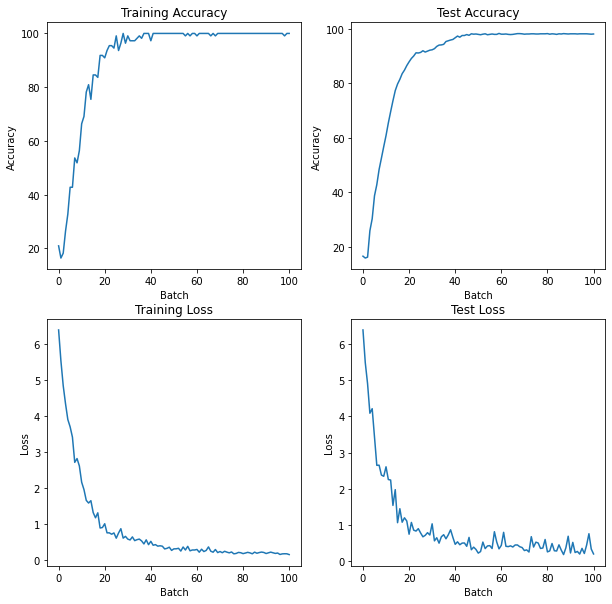

In [22]:
general_utils.plot_acc_loss(train_acc, test_acc, trainloss_, testloss_)

#LR vs Epoch plot

Text(0, 0.5, 'Epoch')

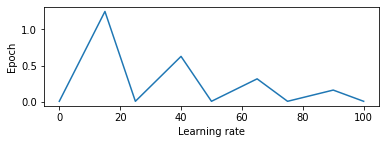

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_)
ax.set_xlabel("Learning rate")
ax.set_ylabel("Epoch")

#Torch jit Save

In [25]:
#torch.save(modelnet.state_dict(), 'Generated_models/Model.pt')
model = net.to('cpu')
model.eval()
compiled_model = torch.jit.trace(model, torch.randn(1,3,160,160))
torch.jit.save(compiled_model, 'Generated_models/Modeljit.pt')

#Load Model

In [4]:
import cudas
device = torch.device("cuda" if cudas.cuda else "cpu")
loaded_compiled_model = torch.jit.load('Generated_models/Modeljit.pt')
loaded_compiled_model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (1): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (2): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
  )
  (3): RecursiveScriptModule(original_name=MaxPool2d)
  (4): RecursiveScriptModule(
    original_name=BasicConv2d
    (conv): RecursiveScriptModule(original_name=Conv2d)
    (bn): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT    Juan_Carlos_Ferrero      Laura_Bush      John_Ashcroft      Colin_Powell      Andre_Agassi      George_W_Bush      Julie_Gerberding      Lance_Armstrong
Pred  Juan_Carlos_Ferrero      Laura_Bush      John_Ashcroft      Colin_Powell      Andre_Agassi      George_W_Bush      Julie_Gerberding      Lance_Armstrong


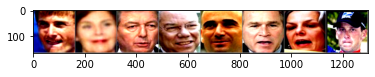

In [8]:
dataiter = iter(testloader1)
images, labels = dataiter.next()

# print images
general_utils.imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j].item()] for j in range(8)))

outputs = loaded_compiled_model(images.to('cpu'))
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j].item()] for j in range(8)))

#Find classifed/Unclassified images

In [15]:
import numpy
def fun(strings, testloaderx):
  dataiter = iter(testloaderx)
  count0 = -1;
  images0 = torch.rand((6, 3, 160, 160))
  label0 = {}; 
  pred0 = {}; 
  while(1):
    if count0==5:
      break
    images, labels = dataiter.next()
    outputs = loaded_compiled_model(images)
    _, predicted = torch.max(outputs, 1)
    j=0
    for j in range(6):
      if classes[labels[j]] == strings:
        if count0<10:
          count0 = count0 + 1
          images0[count0] = images[j]
          label0[count0] = labels[j].numpy()
          pred0[count0] = predicted[j].cpu().data.numpy()
  return images0, label0, pred0  

#Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Aamir_Khan  Pred:  0   Aamir_Khan
GT:  1   Aamir_Khan  Pred:  1   Aamir_Khan
GT:  2   Aamir_Khan  Pred:  2   Aamir_Khan
GT:  3   Aamir_Khan  Pred:  3   Aamir_Khan
GT:  4   Aamir_Khan  Pred:  4   Aamir_Khan
GT:  5   Aamir_Khan  Pred:  5   Aamir_Khan


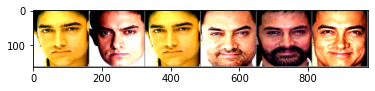

In [6]:
images0, label0, pred0 = fun('Aamir_Khan', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Ajay_Devgn  Pred:  0   Ajay_Devgn
GT:  1   Ajay_Devgn  Pred:  1   Ajay_Devgn
GT:  2   Ajay_Devgn  Pred:  2   Ajay_Devgn
GT:  3   Ajay_Devgn  Pred:  3   Ajay_Devgn
GT:  4   Ajay_Devgn  Pred:  4   Ajay_Devgn
GT:  5   Ajay_Devgn  Pred:  5   Ajay_Devgn


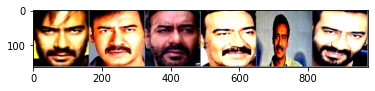

In [7]:
images0, label0, pred0 = fun('Ajay_Devgn', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Akshay_Kumar  Pred:  0   Akshay_Kumar
GT:  1   Akshay_Kumar  Pred:  1   Akshay_Kumar
GT:  2   Akshay_Kumar  Pred:  2   Akshay_Kumar
GT:  3   Akshay_Kumar  Pred:  3   Akshay_Kumar
GT:  4   Akshay_Kumar  Pred:  4   Akshay_Kumar
GT:  5   Akshay_Kumar  Pred:  5   Akshay_Kumar


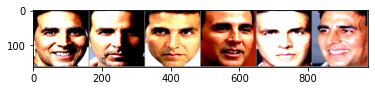

In [8]:
images0, label0, pred0 = fun('Akshay_Kumar', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Anushka_Sharma  Pred:  0   Anushka_Sharma
GT:  1   Anushka_Sharma  Pred:  1   Anushka_Sharma
GT:  2   Anushka_Sharma  Pred:  2   Anushka_Sharma
GT:  3   Anushka_Sharma  Pred:  3   Anushka_Sharma
GT:  4   Anushka_Sharma  Pred:  4   Anushka_Sharma
GT:  5   Anushka_Sharma  Pred:  5   Anushka_Sharma


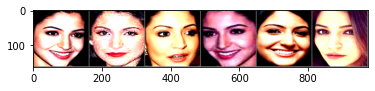

In [9]:
images0, label0, pred0 = fun('Anushka_Sharma', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Deepika_Padukone  Pred:  0   Deepika_Padukone
GT:  1   Deepika_Padukone  Pred:  1   Deepika_Padukone
GT:  2   Deepika_Padukone  Pred:  2   Deepika_Padukone
GT:  3   Deepika_Padukone  Pred:  3   Deepika_Padukone
GT:  4   Deepika_Padukone  Pred:  4   Deepika_Padukone
GT:  5   Deepika_Padukone  Pred:  5   Deepika_Padukone


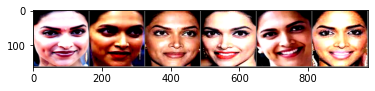

In [10]:
images0, label0, pred0 = fun('Deepika_Padukone', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   MS_Dhoni  Pred:  0   MS_Dhoni
GT:  1   MS_Dhoni  Pred:  1   MS_Dhoni
GT:  2   MS_Dhoni  Pred:  2   MS_Dhoni
GT:  3   MS_Dhoni  Pred:  3   MS_Dhoni
GT:  4   MS_Dhoni  Pred:  4   MS_Dhoni
GT:  5   MS_Dhoni  Pred:  5   MS_Dhoni


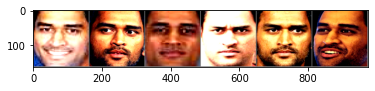

In [11]:
images0, label0, pred0 = fun('MS_Dhoni', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Sharukh_Khan  Pred:  0   Sharukh_Khan
GT:  1   Sharukh_Khan  Pred:  1   Sharukh_Khan
GT:  2   Sharukh_Khan  Pred:  2   Sharukh_Khan
GT:  3   Sharukh_Khan  Pred:  3   Sharukh_Khan
GT:  4   Sharukh_Khan  Pred:  4   Sharukh_Khan
GT:  5   Sharukh_Khan  Pred:  5   Sharukh_Khan


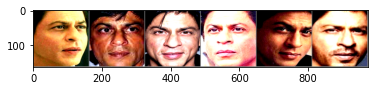

In [7]:
images0, label0, pred0 = fun('Sharukh_Khan', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Sushant_Singh  Pred:  0   Sushant_Singh
GT:  1   Sushant_Singh  Pred:  1   Sushant_Singh
GT:  2   Sushant_Singh  Pred:  2   Sushant_Singh
GT:  3   Sushant_Singh  Pred:  3   Sushant_Singh
GT:  4   Sushant_Singh  Pred:  4   Sushant_Singh
GT:  5   Sushant_Singh  Pred:  5   Sushant_Singh


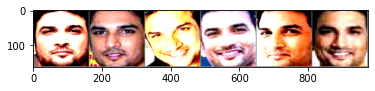

In [9]:
images0, label0, pred0 = fun('Sushant_Singh', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Virat_Kholi  Pred:  0   Virat_Kholi
GT:  1   Virat_Kholi  Pred:  1   Virat_Kholi
GT:  2   Virat_Kholi  Pred:  2   Virat_Kholi
GT:  3   Virat_Kholi  Pred:  3   Virat_Kholi
GT:  4   Virat_Kholi  Pred:  4   Virat_Kholi
GT:  5   Virat_Kholi  Pred:  5   Virat_Kholi


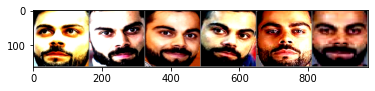

In [10]:
images0, label0, pred0 = fun('Virat_Kholi', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 6):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])

#MisClassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT:  0   Jiang_Zemin  Pred:  0   George_W_Bush
GT:  1   George_HW_Bush  Pred:  1   John_Ashcroft
GT:  2   Lucio_Gutierrez  Pred:  2   Aamir_Khan
GT:  3   Michael_Schumacher  Pred:  3   Ian_Thorpe
GT:  4   George_W_Bush  Pred:  4   Laura_Bush
GT:  5   Jacques_Chirac  Pred:  5   Silvio_Berlusconi
GT:  6   Julianne_Moore  Pred:  6   Recep_Tayyip_Erdogan
GT:  7   Nestor_Kirchner  Pred:  7   Paul_Bremer
GT:  8   Jacques_Chirac  Pred:  8   Ariel_Sharon
GT:  9   Megawati_Sukarnoputri  Pred:  9   Saddam_Hussein


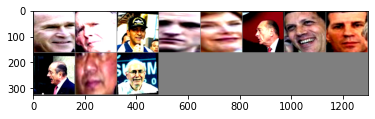

In [16]:
images0, label0, pred0 = fun('Missclassified', testloader1)
general_utils.imshow(torchvision.utils.make_grid(images0))
for j in range(0, 10):
  print('GT: ', j, ' ', classes[label0[j]],' Pred: ', j, ' ', classes[pred0[j]])